# Testing logic with molecules

In [272]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

In [273]:
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy
from dgym.experiment import Experiment

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

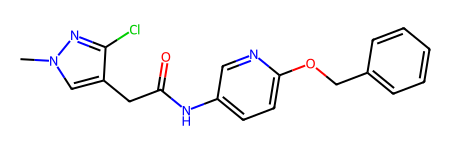

CPU times: user 367 ms, sys: 0 ns, total: 367 ms
Wall time: 37.2 ms


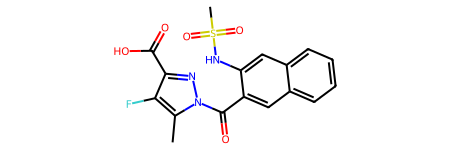

In [313]:
%%time
designer.reset_cache()
res = designer.design(1)[0]
display(res)
molecule = designer.design(molecule=res, size=1, method='random')[0]
molecule

In [314]:
import json

print(json.dumps(molecule.dump(), indent=4))

{
    "product": "Cc1c(F)c(C(=O)O)nn1C(=O)c1cc2ccccc2cc1NS(C)(=O)=O",
    "reaction": "13_Carboxylate_and_Amine",
    "reactants": [
        {
            "product": "CS(=O)(=O)Nc1cc2ccccc2cc1C(=O)O"
        },
        {
            "product": "Cc1[nH]nc(C(=O)O)c1F.Cl"
        }
    ]
}


In [315]:
import itertools

def construct_reaction(reaction_tree, generator):
    """
    Generates LazyReaction products based on a serialized reaction tree.
    
    Parameters:
    - serialized_tree: dict, the serialized reaction tree including SMILES strings.
    - generator: Generator object, used for generating molecules.
    
    Returns:
    - A generator for LazyReaction products.
    """
    # Base case: If tree is a simple molecule, return it appropriate generator
    if 'reactants' not in reaction_tree:
        product = reaction_tree.get('product', None)
        return generator(product, **reaction_tree)

    # Recursive case: Construct reactants and apply reaction
    if 'reaction' in reaction_tree \
        and 'reactants' in reaction_tree:
        reactants = [construct_reaction(reactant, generator) for reactant in reaction_tree['reactants']]
        reaction = reactions[reaction_tree['reaction']]
        return reaction.run(reactants)

    raise Exception('`reaction_tree` must include a reaction or reactants.')

CPU times: user 399 ms, sys: 0 ns, total: 399 ms
Wall time: 47 ms


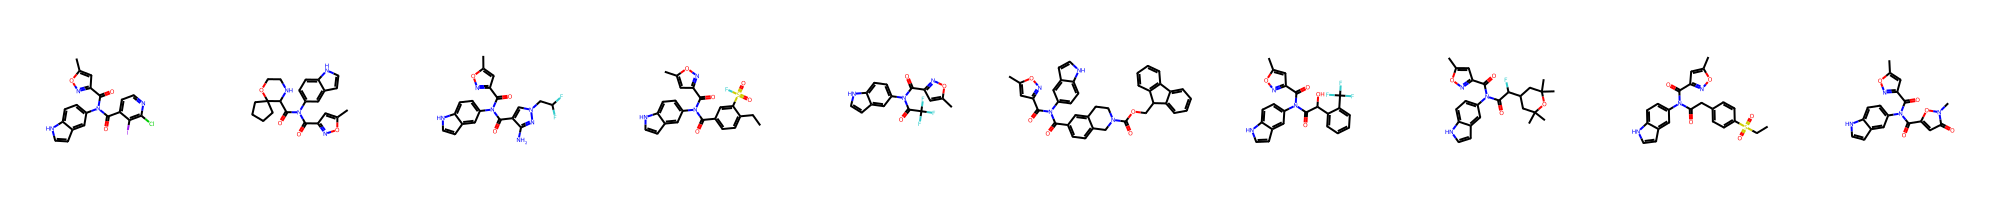

In [373]:
%%time
generator = Generator(building_blocks, fingerprints, sizes)
molecule = deck[20]
products = set()
size = 10

molecule.reaction = designer.match_reactions(molecule)[0]
reaction_tree = molecule.dump()

for reaction in reactions:

    if len(products) >= size:
        break

    reaction_tree_ = {
        'reaction': reaction.name,
        'reactants': [{'product': molecule.smiles}, {'mode': 'random'}]
    }
    analogs = construct_reaction(reaction_tree_, generator)
    
    for analog in analogs:
        analog.inspiration = molecule
        if len(products) < size:
            analog.reactants[0] = molecule
            products.add(analog)
        else:
            break

products = list(products)
from rdkit.Chem.Draw import MolsToGridImage

MolsToGridImage(
    [m.mol for m in products],
    molsPerRow=10,
)

Now, use "similar" strategy **after** a "grow" strategy.

In [351]:
from itertools import combinations
from copy import deepcopy

def flatten_tree(reaction_tree, path=()):
    """
    Flattens the reaction tree to a list of paths to each reactant.

    Parameters
    ----------
    reaction_tree : dict
        The reaction tree to flatten.
    path : tuple
        The current path in the tree, used for internal tracking.

    Returns
    -------
    list
        A list of paths to each reactant in the tree.
    """
    if 'reactants' in reaction_tree and reaction_tree['reactants']:
        paths = []
        for i, reactant in enumerate(reaction_tree['reactants']):
            paths.extend(flatten_tree(reactant, path + (i,)))
        return paths
    else:
        return [path]

def apply_annotation_to_path(reaction_tree, path, method):
    """
    Applies an annotation to a reactant specified by a path.
    This function now utilizes deepcopy to ensure modifications are isolated.

    Parameters
    ----------
    reaction_tree : dict
        The reaction tree.
    path : tuple
        The path to the reactant to be annotated.
    mode : str
        The annotation mode.

    Returns
    -------
    dict
        The reaction tree with the annotation applied.
    """
    if not path:
        return {'product': reaction_tree['product'], 'method': method, **reaction_tree}

    reactants = reaction_tree['reactants']
    for i, step in enumerate(path):
        if i == len(path) - 1:
            reactants[step] = apply_annotation_to_path(reactants[step], (), method)
        else:
            reactants = reactants[step]['reactants']

    return reaction_tree

def annotate_reactants(reaction_tree, method: str = 'similar', num_annotations: int = 1):
    """
    Generates all unique variants of the reaction tree with the specified number of annotations applied.
    Utilizes deepcopy to ensure each variant is a completely separate copy.

    Parameters
    ----------
    reaction_tree : dict
        The initial reaction tree.
    mode : str
        The mode for annotation.
    num_annotations : int
        The number of annotations to apply.

    Returns
    -------
    list
        A list of all unique reaction tree variants with annotations applied.
    """
    paths = flatten_tree(reaction_tree)
    variants = []
    for combo in combinations(paths, num_annotations):
        new_tree = deepcopy(reaction_tree)
        for path in combo:
            new_tree = apply_annotation_to_path(new_tree, path, method)
        variants.append(new_tree)
    return variants

reaction_tree = molecule.dump()
variants = annotate_reactants(reaction_tree, method='similar', num_annotations=1)

In [352]:
import random

def generate_analogs(reaction_tree, method='similar', num_annotations=1):
    """Initialize the reaction system with a random configuration variant."""
    
    # Make variant reaction trees
    variant_trees = annotate_reactants(
        reaction_tree, method=method, num_annotations=num_annotations)
    variant_products = [
        construct_reaction(v, generator) for v in variant_trees]
    
    # Choose tree from which to yield product
    while True:
        chosen_products = random.choice(variant_products)
        yield from chosen_products

In [483]:
designer._annotate_reactants(
    {'reactants': molecule.dump()['reactants']}, method='similar', num_annotations=0
)

[[{'product': 'Nc1ccc2[nH]ccc2c1'}, {'product': 'Cc1cc(C(=O)O)no1'}]]

In [522]:
analogs = generate_analogs(molecule.dump(), method='similar', num_annotations=1)

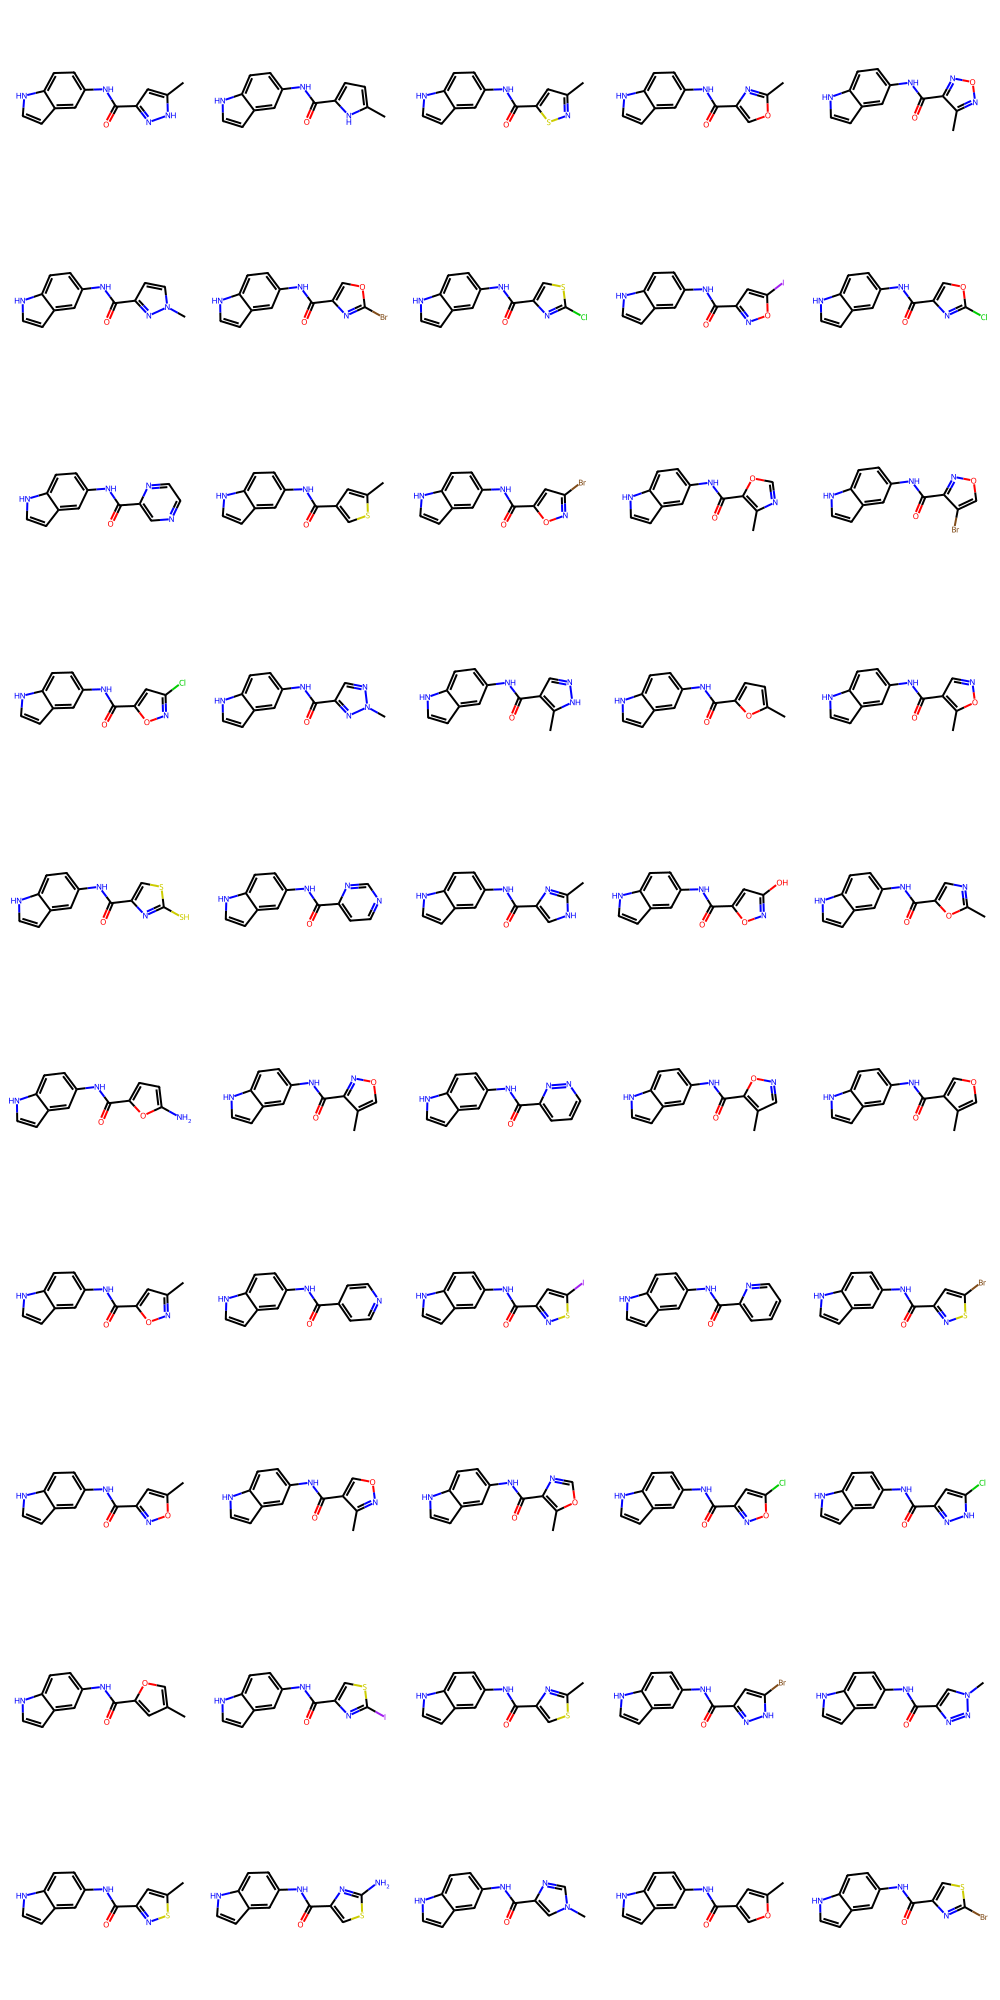

In [417]:
from rdkit.Chem.Draw import MolsToGridImage

analogs = generate_analogs(molecule.dump(), method='similar')

MolsToGridImage(
    set([next(analogs).mol for _ in range(50)]),
    molsPerRow=5,
)